In my last notebook, I used a multilayer perceptron network (MLP) for classification using the MNIST dataset. For this notebook, I will apply a Convolutional Neural Network to the same dataset and see how this network performs| compared to the MLP. 

In [1]:
import tensorflow as tf

In [2]:
import numpy as np
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [4]:
mnist.train.next_batch(10)[0].shape

(10, 784)

### Data

We will be using the MNIST dataset. This dataset contains handwritten digits ranging from 0 - 9. Each image is 28x28 in resolution. Some examples of images in our set:

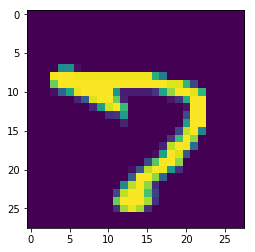

In [25]:
plt.imshow(mnist.train.next_batch(1)[0][0].reshape(28, 28))

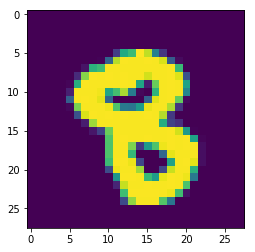

In [26]:
plt.imshow(mnist.train.next_batch(1)[0][0].reshape(28, 28))

### Convolutional Neural Network Model (CNN)
The CNN is similar to the multilayer percepton model we previously did with an addition of two types of layers: the convolution layer and the pooling layer. 

** Convolution Layer** :
Given an image, the convolution layer consists of a matrix (filter), often a matrix smaller than the image, that is multiplied element wise with the image matrix in strides. With each stride, the element wise multiplication is then summed and stored into a new matrix. For example, lets consider the image matrix 

\begin{bmatrix}
1 & 1 & 1 & 0 & 0 \\
0 & 1 & 1 & 1 & 0 \\
0 & 0 & 1 & 1 & 1 \\
0 & 0 & 1 & 1 & 0 \\
0 & 1 & 1 & 0 & 0
\end{bmatrix}
$$
\text{Image}
$$
and we apply this filter matrix to the image with a stride of 1.

\begin{bmatrix}
1 & 0 & 1 \\
0 & 1 & 0 \\
1 & 0 & 1
\end{bmatrix}
$$ \text{Filter}$$

Then the convolved feature matrix will be:
![title](http://engineering.flipboard.com/assets/convnets/Convolution_schematic.gif)

The stride is simply how many pixels we slide our filter matrix over to perform the element wise multiplication and sum. For our example, we used a stride of 1 so notice the filter matrix moves over just one pixel between each operation. 

The filter matrix's purpose is to determine distinctive features of the images we are trying to classify such as edges. The filter is learned when we train our model and at each convolution layer, we can apply multiple filters.

** Pooling Layer **:
The pooling layer is a way to do non-linear down sampling. Max pooling is the most common type of pooling. The max pooling layer partitions the input matrix into non-overlapping sub-regions in a defined number of strides and computes the max of the sub-region and stores the max into a result matrix. An example of max pooling with stride = 2:

![title](https://upload.wikimedia.org/wikipedia/commons/e/e9/Max_pooling.png)

Sources of images:
- http://deeplearning.stanford.edu/wiki/index.php/Feature_extraction_using_convolution

- http://cs231n.github.io/convolutional-networks/

Both the convolution and pooling layers are ways to not only detect distinctive features in our classes, but they also eliminate the number of parameters in our model. This is a huge deal because using a traditional neural network for image classification can be very costly in terms of the number of parameters required. 

** Fun fact:** The structure of a convolutional neural network is motivated by the animal visual cortex. 

The structure of our network will be:

[Convolution --> Convolution --> Max Pooling --> Convolution --> Convolution --> Max Pooling --> Fully Connected --> Fully Connected --> Output]

At each of our convolution layers, we will apply 64 3x3 filters with stride 1. Our max pooling layer will be a max pooling layer of size 2x2 with stride 2.
The 2 fully connected layers will be like our perceptron model, which will contain 512 neurons each. The output layer will have 10 neurons because we have 10 classes.

In [5]:
x = tf.placeholder(tf.float32, shape = [None, 28 * 28])
y = tf.placeholder(tf.float32, shape = [None, 10])

def weight_var(shape):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial)

def bias_var(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides = [1, 1, 1, 1], padding = 'SAME')

def max_pool(x):
    return tf.nn.max_pool(x, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')

In [8]:
x_image = tf.reshape(x, [-1, 28, 28, 1])
#Convolution Layer
W_conv1 = weight_var([3, 3, 1, 64])
b_conv1 = bias_var([64])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

#Convolution Layer
W_conv2 = weight_var([3, 3, 64, 64])
b_conv2 = bias_var([64])

h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2) + b_conv2)
#Max Pool Layer
h_pool1 = max_pool(h_conv2)


#Convolution Layer
W_conv3 = weight_var([3, 3, 64, 64])
b_conv3 = bias_var([64])

h_conv3 = tf.nn.relu(conv2d(h_pool1, W_conv3) + b_conv3)

#Convolution Layer
W_conv4 = weight_var([3, 3, 64, 64])
b_conv4 = bias_var([64])

h_conv4 = tf.nn.relu(conv2d(h_conv3, W_conv4) + b_conv4)

#Max Pool Layer
h_pool2 = max_pool(h_conv4)

#Full Layer
W_fc1 = weight_var([7 * 7 * 64, 512])
b_fc1 = bias_var([512])

h_pool2_flat = tf.reshape(h_pool2,[-1, 7 * 7 * 64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

#Dropout
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#Full Layer
W_fc2 = weight_var([512, 10])
b_fc2 = bias_var([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2


For our output layer, we will use the cross entropy function to produce our logits and will use the ADAM stochastic optimization to train our model. 



In [14]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y, logits = y_conv))
train_step = tf.train.AdamOptimizer(0.001).minimize(cross_entropy)
correct_pred = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y, 1))
acc = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [15]:
%%time
for i in range(20000):
    batch = mnist.train.next_batch(100)
    test_batch = mnist.test.next_batch(100)
    if i % 1000 == 0:
#         train_accuracy = acc.eval(feed_dict = {x:batch[0], y:batch[1], keep_prob: 1.0})
        test_accuracy = acc.eval(feed_dict = {x:test_batch[0], y:test_batch[1], keep_prob: 1.0})
        print('test_accuracy: %g' %(test_accuracy))
    train_step.run(feed_dict = {x: batch[0], y: batch[1], keep_prob: 0.5})

test_accuracy: 0.09
test_accuracy: 0.99
test_accuracy: 0.99
test_accuracy: 1
test_accuracy: 1
test_accuracy: 0.99
test_accuracy: 0.99
test_accuracy: 1
test_accuracy: 1
test_accuracy: 0.99
test_accuracy: 1
test_accuracy: 1
test_accuracy: 1
test_accuracy: 1
test_accuracy: 0.99
test_accuracy: 1
test_accuracy: 1
test_accuracy: 1
test_accuracy: 1
test_accuracy: 0.99
Wall time: 5min 4s


In [16]:
test_accuracy = 0
for i in range(100):
    test_set = mnist.test.next_batch(100)
    test_accuracy += acc.eval(feed_dict = {x:test_set[0], y:test_set[1], keep_prob: 1.0})  
avg_test_acc = test_accuracy/100 * 100
print('average test accuracy %g'%avg_test_acc)

average test accuracy 99.34


We can see that we get much better results from this model than using the multilayer perceptron network (MLP). The MLP network achieved a 96.7% accuracy while our CNN network best it at 99.34%. Training these two networks have been enjoyable on a GPU. The training times on a GPU vs CPU are drastic. The training for the CNN only took a little more than 5 minutes. While it would take more than 30 mins to train on my quad core Macbook Pro CPU.